# **Advanced lecture: 베이지안 최적화 실습**


---


By Mingyu Lee, Hwisang Jo, and Ikjin Lee

http://idol.kaist.ac.kr/

mglee91@kaist.ac.kr

IDOL Lab at KAIST



---

### **< Source papers >**

* Le Gratiet, L. (2013). Multi-fidelity Gaussian process regression for computer experiments (Doctoral dissertation, Université Paris-Diderot-Paris VII).

* **Lee, M.**, Jung, Y., Choi, J., & Lee, I. (2022). A reanalysis-based multi-fidelity (RBMF) surrogate framework for efficient structural optimization. Computers & Structures, 273, 106895.


Original source codes from https://github.com/SMTorg/SMT

Modified version by Mingyu Lee


---


### **< Contents >**


 1) One-dimensional Kriging example

 2) Two-dimensional Kriging example

 3) One-dimensional Co-kriging example

 **4) Bayesian optimization**

# **4) Bayesian optimization**

## **▣ Sequential sampling process 이론 설명**

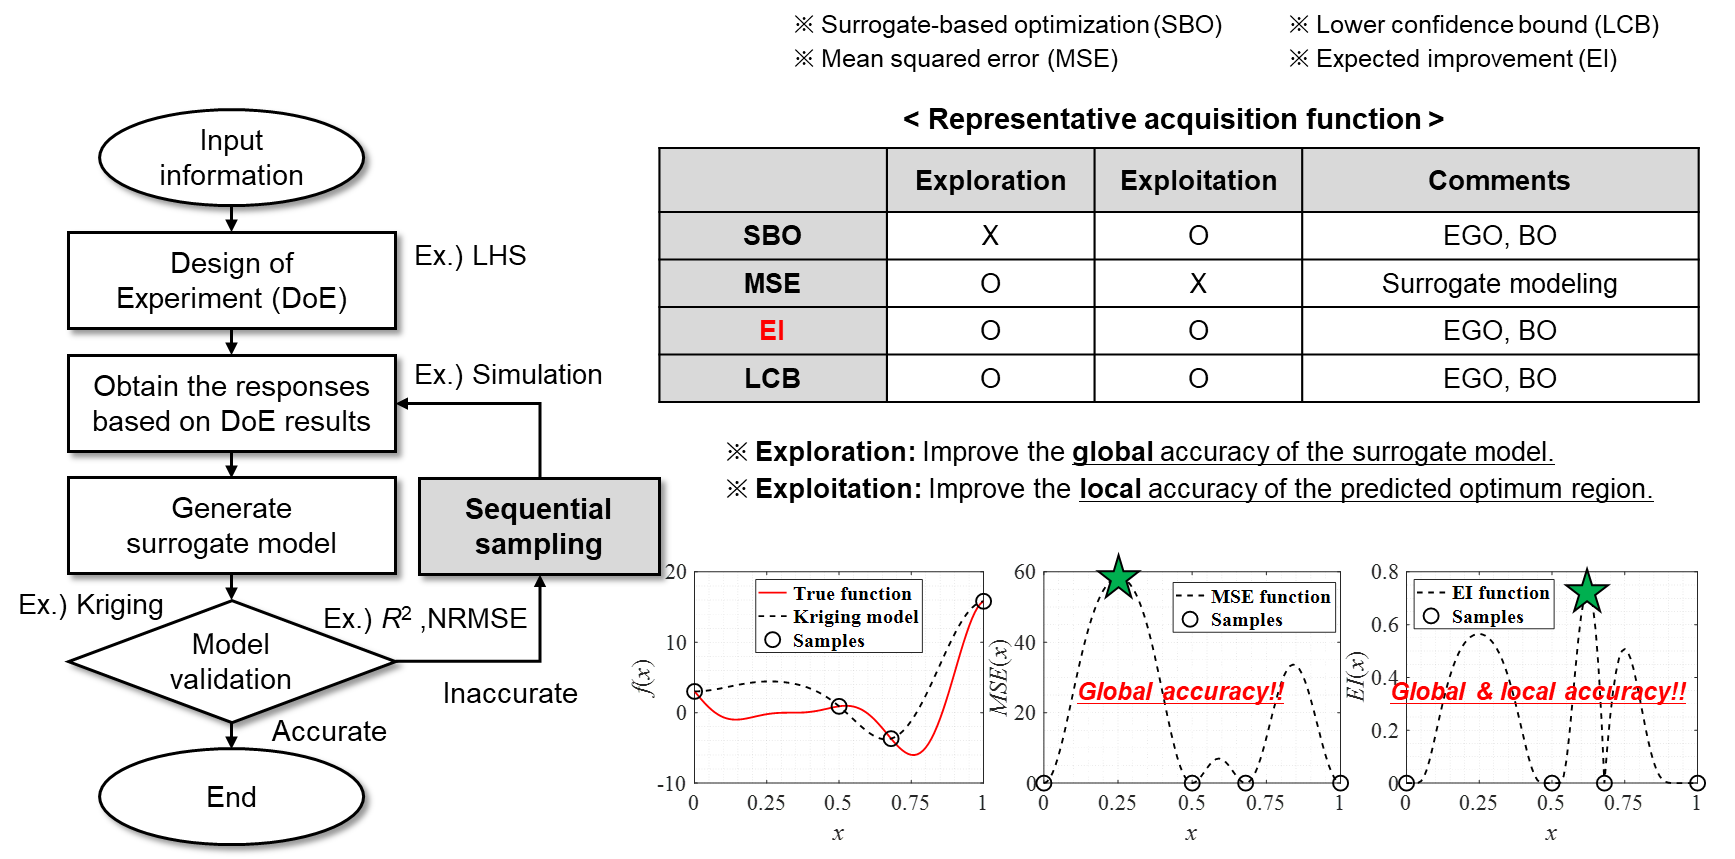

* **Expected improvement (EI) function**
<br/>▷ 확률 기반 대리 모델 (e.g., Kriging)을 이용하여 최적해를 효율적으로 찾기 위해 사용하는 acquisition 함수
<br/>▷ 대리 모델의 평균 예측 값 ($\hat{y}$(**x**))과 불확실성 정보 ($\hat{s}$(**x**))로 구성된 함수

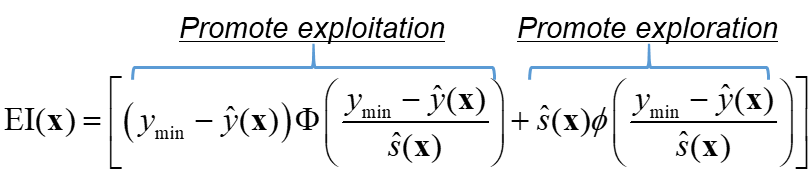

In [1]:
!pip install smt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.9/272.9 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for smt: filename=smt-2.0-cp310-cp310-linux_x86_64.whl size=672654 sha256=8a01603518cbb9ff6e70c18d928aa8c2b8276d5bacfd34cce591145dcf03cce1
  Stored in directory: /root/.cache/pip/wheels/c0/f0/58/98644c8bef7a61927a3835b3fa22d9e09a5bdc53f6505807b6
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25521 sha256=419d849d95031c60bf7e0cf9e951303e13923aa1e5dc3a6e95c803fdf2848002
  Stored in directory: /root/.cache/pip/wheels/46/1f/29/6fda5c72f950841e39147ae603780ee913a62f977b4ad47ee4
Successfully built smt pyDOE2


### ※ **예제 문제**
* 설계 공간: 0~1
* 근사하고자 하는 실제 함수: y = (6x - 2)<sup>2</sup> sin(12x - 4)
* 데이터: x = 0, 0.1, 0.5, 1.0에서 입력 및 출력 값 존재
* Kriging으로 대리모델링을 수행
* Acquisition 함수로 EI사용하여 최적해 찾기
* 실제 최적해: x<sub>opt</sub>=0.7572 에서 *f*(x<sub>opt</sub>)=-6.0207


In [2]:
import numpy as np
from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.utils.design_space import DesignSpace
import matplotlib.pyplot as plt

In [3]:
# 인풋 정보
def HF_function(x): # high-fidelity function
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

n_iter = 4 #샘플 추가 횟수
xlimits = np.array([[0.0, 1.0]]) # 설계 영역 (0~1)
design_space = DesignSpace(xlimits)
xdoe = np.atleast_2d([0, 0.1, 0.5, 1]).T # 입력 데이터
n_doe = xdoe.size

In [6]:
print(xdoe.shape)

(4, 1)


In [7]:
# Sequential sampling process
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
# criterion = "SBO"  #'EI' or 'SBO' or 'LCB'
# criterion = "LCB"  #'EI' or 'SBO' or 'LCB'

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=KRG(design_space=design_space, print_global=False),
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=HF_function)

In [8]:
print("Minimum in x={:.4f} with f(x)={:.4f}".format(float(x_opt), float(y_opt)))
# True minimum in x=0.7572 with f(x)=-6.0207

Minimum in x=0.6892 with f(x)=-4.1189


In [9]:
# 시각화 (Post-processing)
num = 100
x_plot = np.atleast_2d(np.linspace(0, 1, num)).T
y_plot = HF_function(x_plot)

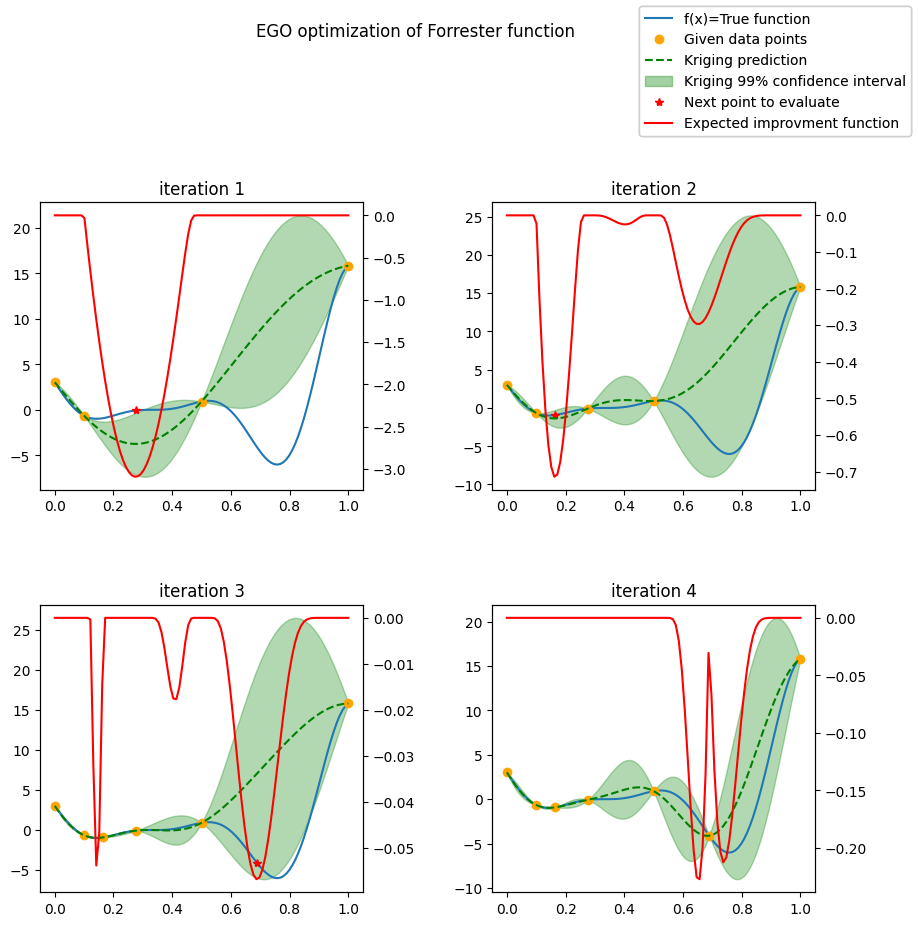

In [10]:
fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + i
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]
    ego.gpr.set_training_values(x_data_k, y_data_k)
    ego.gpr.train()

    y_gp_plot = ego.gpr.predict_values(x_plot)
    y_gp_plot_var = ego.gpr.predict_variances(x_plot)
    y_ei_plot = -ego.EI(x_plot)

    ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
    ax1 = ax.twinx()
    (ei,) = ax1.plot(x_plot, y_ei_plot, color="red")

    (true_fun,) = ax.plot(x_plot, y_plot)
    (data,) = ax.plot(
        x_data_k, y_data_k, linestyle="", marker="o", color="orange"
    )
    if i < n_iter - 1:
        (opt,) = ax.plot(
            x_data[k], y_data[k], linestyle="", marker="*", color="r"
        )
    (gp,) = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")
    sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
    sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
    un_gp = ax.fill_between(
        x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, data, gp, un_gp, opt, ei]
    fig.suptitle("EGO optimization of Forrester function")
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
    ax.set_title("iteration {}".format(i + 1))
    fig.legend(
        lines,
        [
            "f(x)=True function",
            "Given data points",
            "Kriging prediction",
            "Kriging 99% confidence interval",
            "Next point to evaluate",
            "Expected improvment function",
        ],
    )
plt.show()

### ※ **응용 문제**
* 설계 공간: 0~1
* 근사하고자 하는 실제 함수: y = (6x - 2)<sup>2</sup> sin(12x - 4)
* 데이터: x = 0, 0.2, 0.4, 1.0에서 입력 및 출력 값 존재
* Kriging으로 대리모델링을 수행
* Acquisition 함수로 EI사용하여 최적해 찾기
* 실제 최적해: x<sub>opt</sub>=0.7597 에서 *f*(x<sub>opt</sub>)=-6.0175


In [ ]:
# 인풋 정보
def HF_function(x): # high-fidelity function
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

n_iter = 8
xlimits = np.array([[0.0, 1.0]]) # 설계 영역 (0~1)
design_space = DesignSpace(xlimits)
xdoe = np.atleast_2d([0, 0.1, 0.5, 1]).T # 입력 데이터
n_doe = xdoe.size

criterion = "EI"  #'EI' or 'SBO' or 'LCB'
# criterion = "SBO"  #'EI' or 'SBO' or 'LCB'
# criterion = "LCB"  #'EI' or 'SBO' or 'LCB'

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=KRG(design_space=design_space, print_global=False),
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=HF_function)

print("Minimum in x={:.4f} with f(x)={:.4f}".format(float(x_opt), float(y_opt)))
# True minimum in x=0.7572 with f(x)=-6.0207

Minimum in x=0.1426 with f(x)=-0.9863


### ※ **정답 코드**

In [38]:
# 인풋 정보
def HF_function(x): # high-fidelity function
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

n_iter = 10  # original = 8
xlimits = np.array([[0.0, 1.0]]) # 설계 영역 (0~1)
design_space = DesignSpace(xlimits)
xdoe = np.atleast_2d([0, 0.2, 0.4, 1]).T # 입력 데이터
n_doe = xdoe.size

criterion = "EI"  #'EI' or 'SBO' or 'LCB'
# criterion = "SBO"  #'EI' or 'SBO' or 'LCB'
# criterion = "LCB"  #'EI' or 'SBO' or 'LCB'

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=KRG(design_space=design_space, print_global=False),
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=HF_function)

print("Minimum in x={:.4f} with f(x)={:.4f}".format(float(x_opt), float(y_opt)))
# True minimum in x=0.7572 with f(x)=-6.0207

Minimum in x=0.7599 with f(x)=-6.0171


In [39]:
# 시각화 (Post-processing)
num = 100
x_plot = np.atleast_2d(np.linspace(0, 1, num)).T
y_plot = HF_function(x_plot)

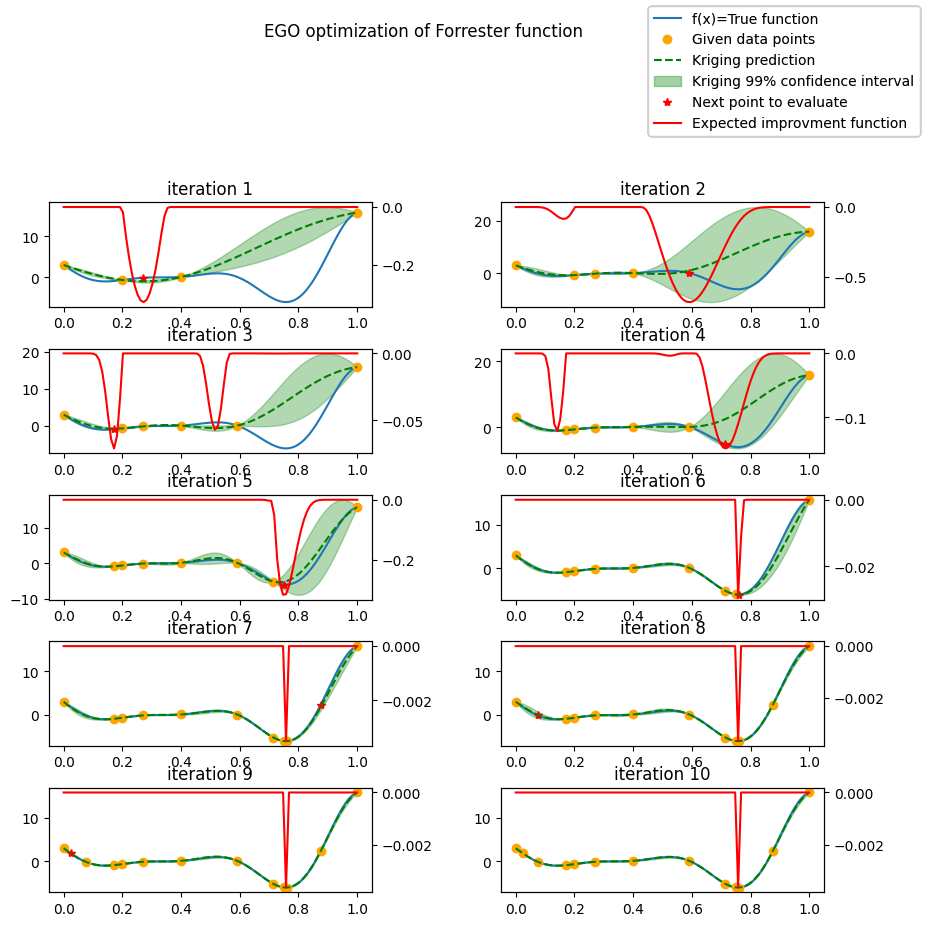

In [40]:
fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + i
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]
    ego.gpr.set_training_values(x_data_k, y_data_k)
    ego.gpr.train()

    y_gp_plot = ego.gpr.predict_values(x_plot)
    y_gp_plot_var = ego.gpr.predict_variances(x_plot)
    y_ei_plot = -ego.EI(x_plot)
    # y_ei_plot = -ego.LCB(x_plot)
    # y_ei_plot = -ego.SBO(x_plot)

    ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
    ax1 = ax.twinx()
    (ei,) = ax1.plot(x_plot, y_ei_plot, color="red")

    (true_fun,) = ax.plot(x_plot, y_plot)
    (data,) = ax.plot(
        x_data_k, y_data_k, linestyle="", marker="o", color="orange"
    )
    if i < n_iter - 1:
        (opt,) = ax.plot(
            x_data[k], y_data[k], linestyle="", marker="*", color="r"
        )
    (gp,) = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")
    sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
    sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
    un_gp = ax.fill_between(
        x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, data, gp, un_gp, opt, ei]
    fig.suptitle("EGO optimization of Forrester function")
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
    ax.set_title("iteration {}".format(i + 1))
    fig.legend(
        lines,
        [
            "f(x)=True function",
            "Given data points",
            "Kriging prediction",
            "Kriging 99% confidence interval",
            "Next point to evaluate",
            "Expected improvment function",
        ],
    )
plt.show()